#### DESAFIO I - CINÉTICA QUÍMICA

Este desafio consiste em representar uma reação química de hidrólise da água, envolvendo as partículas de oxigênio e hidrogênio, considerando suas respectivas velocidades médias, as colisões elásticas entre elas e a mudança de temperatura.

In [1]:
# Importações

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
from itertools import combinations

Definição da quantidade de partículas e suas respectivas posições aleatoriamente

In [2]:
n_particulas = 100
r = np.random.random((2, n_particulas)) # posições x e y
pxh = r[0]>0.5 #posição das partículas a direita
pxo = r[0]<=0.5 #posição das partículas a esquerda

Índice de cada partícula

In [3]:
id_particula = np.arange(n_particulas)

Velocidade média das partículas é dada por
$$\bar{v} = \sqrt{\frac{3K_BT}{M}}$$

In [4]:
#Definição das variáveis da equação
T = 25+273.15 # °K - Temperatura
M_hidro = 2*(1.008/6.02214076*10**(-26)) # kg/mol - massa do hidrogênio
M_oxi = 2*(15.999/6.02214076*10**(-26)) # kg/mol - massa do oxigênio
k = 1.380649*10**(-23) #m²kg/s²K - Constante de Boltzmann

# Matriz para armazenamento dos valores de velocidade inicial
v = np.zeros((2, n_particulas))

# Velocidade inicial em relação ao eixo x para as partículas de hidrogênio e oxigênio
v[0][pxh] = -((3*k*T)/(M_hidro))**(1/2)
v[0][pxo] = ((3*k*T)/(M_oxi))**(1/2)
# print(v[0][pxo][1])

Identificação das possíveis combinações não repetitivas de duas partículas em uma colisão

In [5]:
id_pares = np.asarray(list(combinations(id_particula, 2)))
# print(id_pares)

Obtenção da combinação não repetitiva de posições x e y para os pares de partículas em uma colisão

In [6]:
# Obtenção das posições x e y para os pares de partículas em uma colisão

x_pares = np.asarray(list(combinations(r[0],2)))
y_pares = np.asarray(list(combinations(r[1],2)))
print(y_pares)

[[0.46572303 0.15025492]
 [0.46572303 0.67551721]
 [0.46572303 0.33567916]
 ...
 [0.72752613 0.41002434]
 [0.72752613 0.66679975]
 [0.41002434 0.66679975]]


Obtenção da diferença entre as distâncias dos pares de partículas nas posições x e y

In [7]:
dx_pares = np.diff(x_pares, axis=1).ravel() # matriz unidimensional
dy_pares = np.diff(y_pares, axis=1).ravel()
# print(dy_pares)

A distância euclidiana é dada por $d_{ij}=\sqrt{(\Delta(x^2_{ij}+\Delta(y^2_{ij})}$

In [8]:
d_pares = np.sqrt(dx_pares**2 + dy_pares**2)
# print(d_pares)

Na colisão elástica entre as partículas, há a conservação de energia, momento e momento angular. A velocidade após a colisão entre as partículas pode ser dada por:

$$\vec{v}_1^{\text{colisão}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{colisão}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

A colisão entre as partículas pode ser determinada quando a posição entre elas é menor que seu diâmetro.

In [9]:
raio_hidro = 0.053/10 #nm/10
raio_oxi = 0.06/10 #nm/10
diametro = raio_hidro+raio_oxi
id_colisao_particula = id_pares[d_pares == diametro]

In [10]:
v1 = v[:,id_colisao_particula[:,0]]
v2 = v[:,id_colisao_particula[:,1]]
r1 = r[:,id_colisao_particula[:,0]]
r2 = r[:,id_colisao_particula[:,1]]

Velocidade após a colisão

In [11]:
v1_colisao = np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0)*(r1-r2)

In [12]:
# Variação das distâncias
def delta_pares(x, id_pares):
    return np.diff(np.array([x[id_pares[:,0]], x[id_pares[:,1]]]).T, axis=1).ravel()

# Variação da diferença entre as distâncias
def deltad_pares(r, id_pares):
    return np.sqrt(delta_pares(r[0], id_pares)**2 + delta_pares(r[1], id_pares)**2)

# Velocidade após a colisão entre as partículas
def velocidade_colisao(v1, v2, r1, r2):
    v1_colisao = v1 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2_colisao = v2 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1_colisao, v2_colisao

# Define o movimento das partículas de acordo com a posição e a velocidade
def movimento(r, v, id_pares, ts, dt, corte):
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    
    # Posição e velocidade iniciais
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1,ts):
        ic = id_pares[deltad_pares(r, id_pares) < corte]
        v[:,ic[:,0]], v[:,ic[:,1]] = velocidade_colisao(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        # Restrição para as partículas colidirem com as paredes da caixa e voltarem na direção oposta
        v[0,r[0]>1] = -np.abs(v[0,r[0]>1])
        v[0,r[0]<0] = np.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -np.abs(v[1,r[1]>1])
        v[1,r[1]<0] = np.abs(v[1,r[1]<0])
        
        # A posição é atualizada a cada instante de tempo em relação à velocidade
        r = r + v*dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

In [13]:
# Configuração da quantidade de passos no tempo e variação do tempo 
ts = 1000
dt = 0.00005
corte = diametro
rs, vs = movimento(r, v, id_pares, ts, dt, corte)

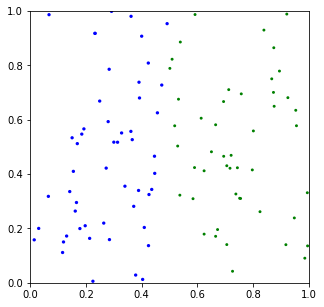

In [14]:
# Representação gráfica
fig, ax = plt.subplots(1,1,figsize=(5,5))
x_hidro, y_hidro = rs[0][0][pxh], rs[0][1][pxh]
x_oxi, y_oxi = rs[0][0][pxo],rs[0][1][pxo]
particula_hidro = [plt.Circle((xi, yi), radius=raio_hidro, linewidth=0) for xi,yi in zip(x_hidro,y_hidro)]
particula_oxi = [plt.Circle((xi, yi), radius=raio_oxi, linewidth=0) for xi,yi in zip(x_oxi,y_oxi)]
c_hidro = matplotlib.collections.PatchCollection(particula_hidro, facecolors='green')
c_oxi = matplotlib.collections.PatchCollection(particula_oxi, facecolors='blue')
ax.add_collection(c_hidro)
ax.add_collection(c_oxi)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Distribuição de velocidades das partículas de Maxwell-Boltzmann em duas dimensões:

$$kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$$
$$\boxed{f(v) = \frac{mv}{kT} \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$$

In [15]:
# Distribuição de Maxwell-Boltzmann aplicada para cada tipo de partícula
v = np.linspace(0,10000,1000)
# print(v)

fv_h = M_hidro*np.exp(-M_hidro*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
fv_o = M_oxi*np.exp(-M_oxi*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
#print(fv_h)

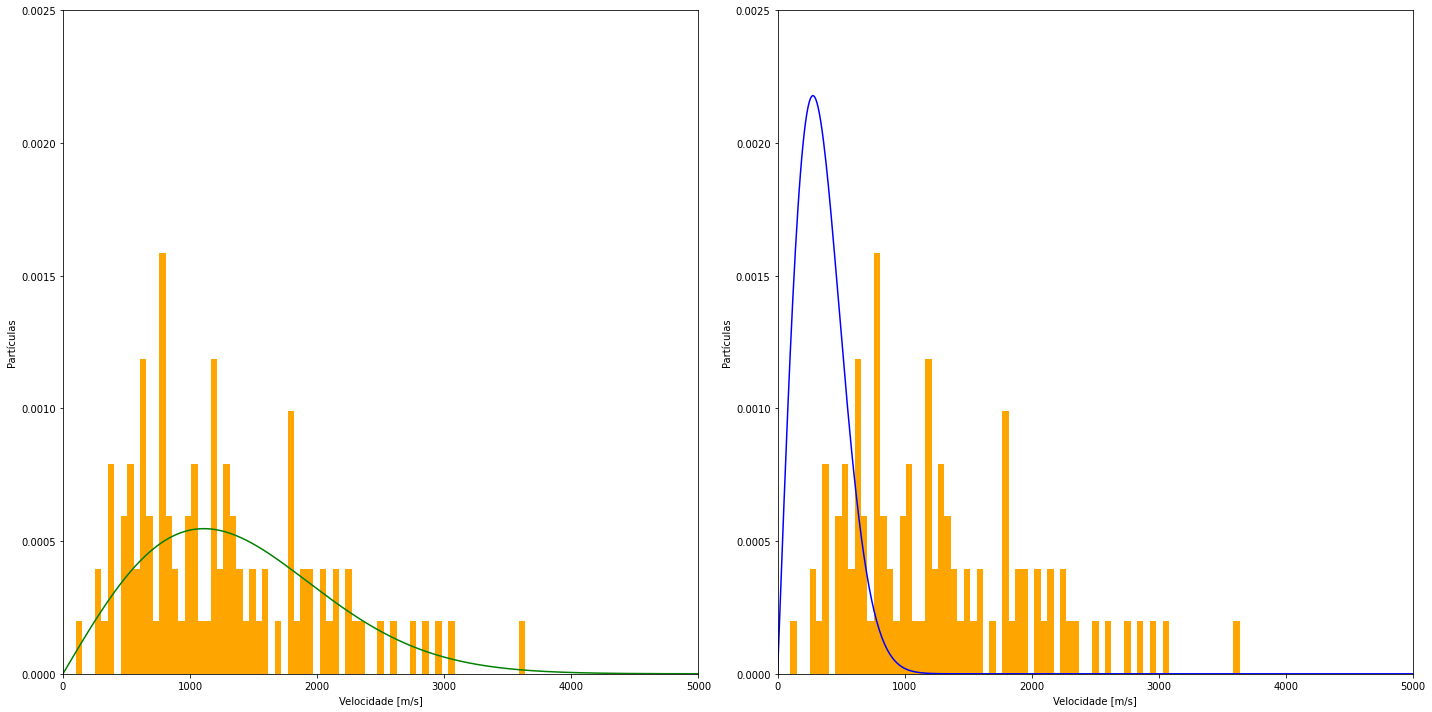

In [16]:
# Representação gráfica
intervalo = np.linspace(0,5000,100)
fig, axes = plt.subplots(1, 2, figsize=(20,10))
ax = axes[0]
ax.hist(np.sqrt(np.sum(vs[-1]**2, axis=0)), bins=intervalo, density=True, color='orange')
ax.plot(v,fv_h, color='green')
ax.set_xlabel('Velocidade [m/s]')
ax.set_ylabel('Partículas')
ax.set_xlim(0,5000)
ax.set_ylim(0,0.0025)
ax = axes[1]
ax.hist(np.sqrt(np.sum(vs[-1]**2, axis=0)), bins=intervalo, density=True, color='orange')
ax.plot(v,fv_o, color='blue')
ax.set_xlabel('Velocidade [m/s]')
ax.set_ylabel('Partículas')
ax.set_xlim(0,5000)
ax.set_ylim(0,0.0025)
fig.tight_layout()

Gera a animação no formato .gif 

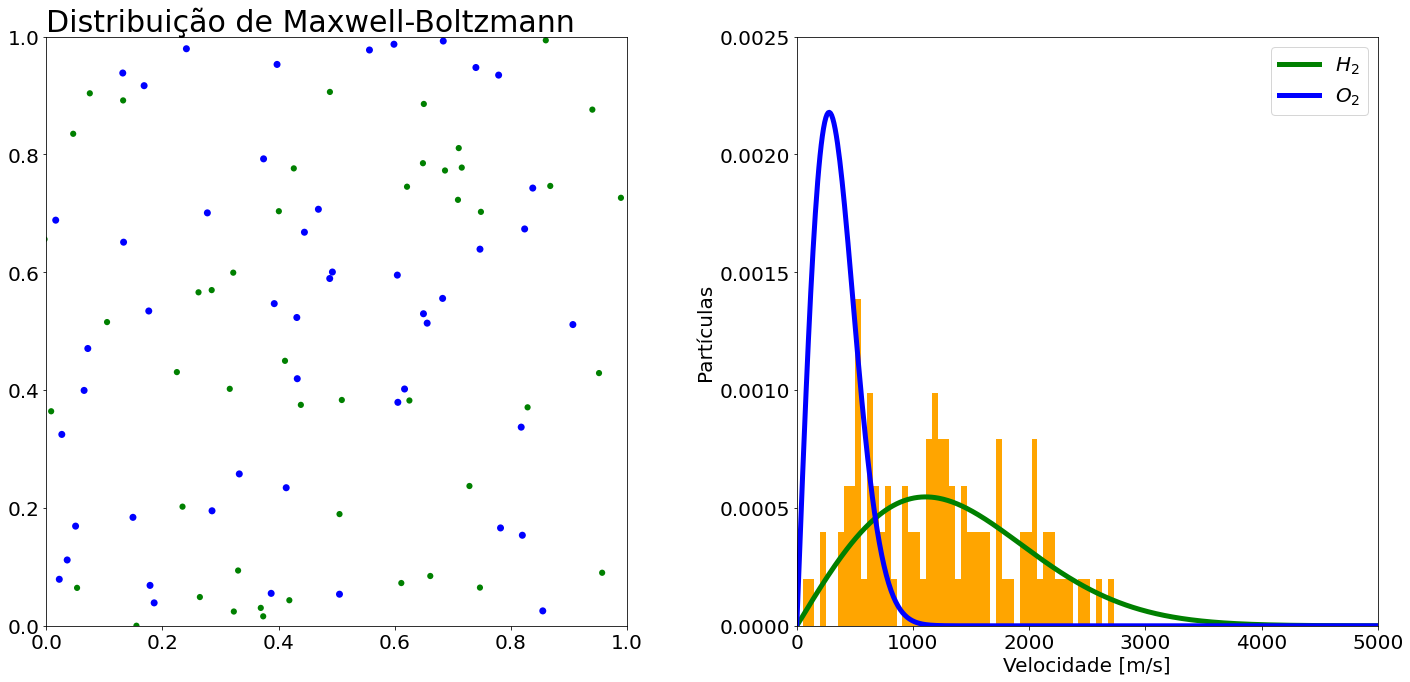

In [17]:
intervalo = np.linspace(0,5000,100)

fig, axes = plt.subplots(1, 2, figsize=(20,10))

def animacao(i):
    [ax.clear() for ax in axes]
    
    ax = axes[0]
    x_hidro, y_hidro = rs[i][0][pxh], rs[i][1][pxh]
    x_oxi, y_oxi = rs[i][0][pxo],rs[i][1][pxo]
    particula_hidro = [plt.Circle((xi, yi), radius=raio_hidro, linewidth=0) for xi,yi in zip(x_hidro,y_hidro)]
    particula_oxi = [plt.Circle((xi, yi), radius=raio_oxi, linewidth=0) for xi,yi in zip(x_oxi,y_oxi)]
    c_hidro = matplotlib.collections.PatchCollection(particula_hidro, facecolors='green')
    c_oxi = matplotlib.collections.PatchCollection(particula_oxi, facecolors='blue')
    ax.add_collection(c_hidro)
    ax.add_collection(c_oxi)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title('Distribuição de Maxwell-Boltzmann', loc='left', size=30)
    plt.rcParams['legend.fontsize'] = 20
    
    ax = axes[1]
    ax.hist(np.sqrt(np.sum(vs[i]**2, axis=0)), bins=intervalo, density=True, color='orange')
    ax.plot(v,fv_h, color='green', label='$H_2$', linewidth=5)
    ax.set_xlabel('Velocidade [m/s]', size=20)
    ax.set_ylabel('Partículas', size=20)
    ax.set_xlim(0,5000)
    ax.set_ylim(0,0.0025)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.rcParams['legend.fontsize'] = 20
    
    ax = axes[1]
    ax.hist(np.sqrt(np.sum(vs[i]**2, axis=0)), bins=intervalo, density=True, color='orange')
    ax.plot(v,fv_o, color='blue', label='$O_2$', linewidth=5)
    ax.set_xlabel('Velocidade [m/s]', size=20)
    ax.set_ylabel('Partículas', size=20)
    ax.set_xlim(0,5000)
    ax.set_ylim(0,0.0025)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.rcParams['legend.fontsize'] = 20
    
    plt.legend()
    fig.tight_layout()
    
ani = animation.FuncAnimation(fig, animacao, frames=150, interval=50)
ani.save('colisão-2D-25.gif',writer='pillow',fps=30,dpi=100)